In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:

import torch
from torch.utils.data import Dataset,DataLoader
from torch import nn

In [5]:
start , end = 0,10
num_samples = 100
x_data = np.linspace(start,end,num_samples)
y_data = -x_data**2 + 10*x_data + 5 + np.random.normal(loc = 0,scale = 0.1,size=num_samples)

x_ref = x_data.reshape(-1,1)
y_ref = y_data.reshape(-1,1)

In [6]:
from sklearn.model_selection import train_test_split
class custom_dataset(Dataset):
    def __init__(self,x_data,y_data):
        super().__init__()
        self.x_data = torch.tensor(x_data,dtype=torch.float32)
        self.y_data = torch.tensor(y_data,dtype=torch.float32)
    def __len__(self):
        return self.x_data.shape[0]
    def __getitem__(self,idx):
        return self.x_data[idx] , self.y_data[idx]
x_train,x_test,y_train,y_test = train_test_split(x_data.reshape(-1,1),y_data.reshape(-1,1))
train_dataloader = DataLoader(custom_dataset(x_train,y_train),batch_size=32,shuffle=True)
test_dataloader =  DataLoader(custom_dataset(x_test,y_test),batch_size=32,shuffle=True)

In [65]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear = nn.Sequential(
            nn.Linear(1,50),
            nn.ReLU(),
            nn.Linear(50,1)
        )
    def forward(self,data):
        return self.linear(data)
        

In [66]:
def config_device():
    device = None
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(device)
    return device
device = config_device()

mps


In [67]:
from torch.optim import SGD

model = Model()
model.to(device)

epoch,lr = 1000,1e-1
momentum, weight_decay = 0.999,5e-3

#optimizer = SGD(model.parameters(),lr = lr,momentum=momentum,weight_decay=weight_decay)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-2,
    weight_decay=1e-4
)
loss_fn = nn.MSELoss()
loss = 0

model.train()
for i in range(epoch):
    running_loss = 0.0
    for x_data,y_data in train_dataloader:
        optimizer.zero_grad()
        x_data,y_data = x_data.to(device),y_data.to(device)
        y_pred = model(x_data)
        loss = loss_fn(y_pred,y_data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

In [68]:
x_plot = np.linspace(start,end,num_samples).reshape(-1,1)
x_plot = torch.tensor(x_plot,dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
 y_plot = model(x_plot)

x_plot = x_plot.cpu().numpy()
y_plot = y_plot.cpu().numpy()

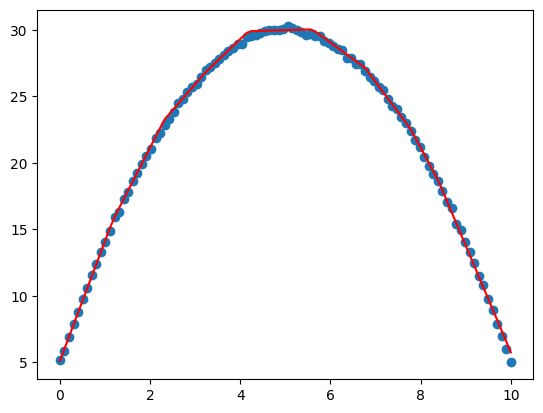

In [69]:
plt.figure()
plt.scatter(x_ref[:,0],y_ref[:,0])
plt.plot(x_plot[:,0],y_plot[:,0],c = 'r')